# IMPORTS

In [1]:
import torch
import torch.nn as nn
from pymonntorch import Behavior, SynapseGroup, Network, NeuronGroup, Recorder, EventRecorder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express
import numpy as np
from matplotlib.pyplot import  Button, Slider
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
import cv2
import os

from DoG import DoG

In [2]:
def show_img_and_filter(x):
    return Image.fromarray(np.array(x).astype(np.uint8))

# CONFIGS

In [3]:
SIZE_X = 28
SIZE_Y = 28

STRIDE_CONV = 1
PADDING = 0
KERNEL_SIZES = [5, 5]
POOLING_STRIDE = 2
POOLING_SIZE = [2, 2]

SIGMAS_1 = [2, 3]
SIGMAS_2 = [8, 9]

MINI_BATCH_SIZE = 1
NUMBER_OF_FEATURES = 2
NUMBER_OF_CHANNELS = 1

OUT_CONV_W = (((SIZE_X + 2*PADDING - KERNEL_SIZES[0]) // STRIDE_CONV) + 1)
OUT_CONV_H = (((SIZE_Y + 2*PADDING - KERNEL_SIZES[1]) // STRIDE_CONV) + 1)

OUT_POOL_W = ((OUT_CONV_W - POOLING_SIZE[0]) // POOLING_STRIDE) + 1
OUT_POOL_H = ((OUT_CONV_H - POOLING_SIZE[1]) // POOLING_STRIDE) + 1

EXC_SIZE1 = SIZE_X * SIZE_Y
EXC_SIZE2 = NUMBER_OF_FEATURES * MINI_BATCH_SIZE * OUT_CONV_W * OUT_CONV_H
EXC_SIZE3 = NUMBER_OF_FEATURES * MINI_BATCH_SIZE * OUT_POOL_W * OUT_POOL_H

ITER = 2800

I_EXC_NOISE1 = torch.zeros(size=(ITER,EXC_SIZE1))
I_EXC_NOISE2 = torch.zeros(size=(ITER,EXC_SIZE2))
I_EXC_NOISE3 = torch.zeros(size=(ITER,EXC_SIZE3))

In [4]:
CURRENT_EXC1 = I_EXC_NOISE1
CURRENT_EXC2 = I_EXC_NOISE2
CURRENT_EXC3 = I_EXC_NOISE3

# DOG FILTERS

In [5]:
def dog_weights(sigma1, sigma2, filter_size):
    dog = DoG(sigma1=sigma1, sigma2=sigma2, kernel_size=filter_size)
    dog_filter = torch.unsqueeze(dog.DoGFilter(), dim=0)
    return dog_filter

In [6]:
# W = torch.Tensor(NUMBER_OF_FEATURES, NUMBER_OF_CHANNELS, *KERNEL_SIZES)
# for i in range(NUMBER_OF_FEATURES):
#     W[i] = dog_weights(SIGMAS_1[i], SIGMAS_2[i], KERNEL_SIZES[0])
    
W = torch.clamp(torch.rand(NUMBER_OF_FEATURES, NUMBER_OF_CHANNELS, *KERNEL_SIZES), 0, 1)

# TTFS ENCODING

In [7]:
class TimeToFirstSpike():

    def __init__(self,img, time_window):
        self.img = img
        self.img_show = self.img.clone()
        self.img = cv2.resize(np.array(self.img), (SIZE_X,SIZE_Y))
        self.img = torch.from_numpy(self.img)
        self.time_window = time_window

    def encode(self):
        self.img = abs(self.img - 255) *(self.time_window-1) // 255
        self.spikes = torch.Tensor(self.time_window, *self.img.size(), device="cpu")
        for time in range(self.time_window):
            spikes_bool = self.img == time
            self.spikes[time] = spikes_bool
        return self.spikes.view(self.time_window, self.img.shape[0]*self.img.shape[1]), self.spikes
    
    def raster_plot(self, spikes):
        self.spikes = spikes
        plt.figure(figsize=(20,8))
        plt.scatter(torch.nonzero(self.spikes, as_tuple=True)[0], torch.nonzero(self.spikes, as_tuple=True)[1])
        plt.xlabel("Time")
        plt.ylabel("Neurons")
        plt.title('Raster Plot')
        plt.xlim(-1,self.time_window)
        plt.show()

# MAKING PATTERN

In [8]:
pattern = []
pattern_non = torch.zeros((20, EXC_SIZE1))
time_window = 50
face_paths = os.listdir('f')
dog_paths = os.listdir('dog')
for i, (face_path, dog_path) in enumerate(zip(face_paths, dog_paths)):
    it = i
    
    face_orginal = Image.open('f/'+face_path).convert('L')
    face_orginal = cv2.resize(np.array(face_orginal), (SIZE_X, SIZE_Y))
    face_orginal = np.array(face_orginal, 'f')
    face_orginal = torch.from_numpy(face_orginal)
    
    dog_orginal = Image.open('dog/'+dog_path).convert('L')
    dog_orginal = cv2.resize(np.array(dog_orginal), (SIZE_X, SIZE_Y))
    dog_orginal = np.array(dog_orginal, 'f')
    dog_orginal = torch.from_numpy(dog_orginal)
    
    ttfs_face = TimeToFirstSpike(face_orginal, time_window)
    spike_flatten_ttfs_face, spikes_ttfs_face = ttfs_face.encode()
    pattern.append(spike_flatten_ttfs_face)
    pattern.append(pattern_non)
    
    ttfs_dog = TimeToFirstSpike(dog_orginal, time_window)
    spike_flatten_ttfs_dog, spikes_ttfs_dog = ttfs_dog.encode()
    # pattern.append(spike_flatten_ttfs_dog)
    # pattern.append(pattern_non)

In [9]:
pattern = torch.cat(pattern, 0)

In [10]:
pattern.shape

torch.Size([2800, 784])

# FIRST LAYER

In [11]:
class LIF_inputlayer(Behavior):
    
    def initialize(self, neurons):
        self.add_tag("LIF_firstLayer")
        self.set_parameters_as_variables(neurons)
        neurons.spikes = neurons.vector("uniform")
        
    def forward(self, neurons):
        neurons.spikes = neurons.spike_iter[neurons.iteration-1].bool()

# SECOND LAYER

In [12]:
class LIF_output(Behavior):
    
    def initialize(self, neurons):
        super().initialize(neurons)
        self.add_tag("LIF_secondlayer")
        self.set_parameters_as_variables(neurons)
        neurons.v = neurons.vector("uniform") * (neurons.threshold - neurons.v_reset) * 1.1
        neurons.v += neurons.v_reset
        neurons.spikes = neurons.vector('zeros')
        
    def dv_dt(self, neurons):
        leakage = -(neurons.v - neurons.v_rest)
        return ((leakage + (neurons.R * neurons.I)) / neurons.tau) * neurons.dt
        
    def forward(self, neurons):
        neurons.v += self.dv_dt(neurons)
        neurons.spikes = neurons.v > neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

# DENDRITE

In [13]:
class Dendrite(Behavior):

    def forward(self, neurons):
        neurons.I = neurons.E_I[neurons.iteration-1]
        for synapse in neurons.afferent_synapses['GLUTAMATE']:
            neurons.I += synapse.I

In [14]:
class Dendrite2(Behavior):

    def forward(self, neurons):
        neurons.I = neurons.E_I[neurons.iteration-1]
        for synapse in neurons.afferent_synapses['GLUTAMATE2']:
            neurons.I += synapse.I

# TRACE

In [15]:
class Trace(Behavior):
    
    def initialize(self, synapse):
        self.add_tag("Trace")
        self.tau = self.parameter("tau", None)
        synapse.src.trace = synapse.src.vector(mode="zeros")
        synapse.dst.trace = synapse.dst.vector(mode="zeros")

    def trace(self, synapse):
        d_trace_src = -1 * synapse.src.trace/self.tau + synapse.src.spikes
        d_trace_dst = -1 * synapse.dst.trace/self.tau + synapse.dst.spikes
        return d_trace_src, d_trace_dst
    
    def forward(self, synapse):
        d_trace_src, d_trace_dst = self.trace(synapse)
        synapse.src.trace += d_trace_src
        synapse.dst.trace += d_trace_dst

In [16]:
class Trace2(Behavior):
    
    def initialize(self, neurons):
        self.add_tag("Trace")
        self.tau = self.parameter("tau", None)
        neurons.trace = neurons.vector(mode="zeros")

    def trace(self, neurons):
        d_trace = -1 * neurons.trace/self.tau + neurons.spikes
        return d_trace
    
    def forward(self, neurons):
        d_trace = self.trace(synapse)
        neurons.trace += d_trace

# CONVOLUTIONAL CONNECTION

In [17]:
class ConvolutionalConnection(Behavior):
    
    def initialize(self, synapse):
        synapse.kernel_size = self.parameter("kernel_size", None)
        synapse.stride_conv = self.parameter("stride_conv", None)
        synapse.padding = self.parameter("padding", None)
        self.coef = self.parameter("coef", None)
        synapse.W = self.parameter('W', None)
        # if synapse.kernel_size[0] % 2 == 1:
        #     synapse.padding = (synapse.kernel_size[0]-1) // 2
        # else:
        #     synaspe.padding = synapse.kernel_size[0] // 2
        
    def forward(self, synapse):
        pre_spikes = synapse.src.spikes.float()
        pre_spikes = pre_spikes.view(MINI_BATCH_SIZE, NUMBER_OF_CHANNELS, SIZE_X, SIZE_Y)
        I = nn.functional.conv2d(input=pre_spikes, weight=synapse.W, stride=synapse.stride_conv, padding=synapse.padding)
        synapse.I = I.flatten() * self.coef
        # print(synapse.I)

In [18]:
spikes_pooling = []
spikes_conv = []

# POOLING CONNECTION

In [19]:
class PoolingConnection(Behavior):
    
    def initialize(self, synapse):
        self.pooling_stride = self.parameter("pooling_stride", 2)
        self.pooling_size = self.parameter("pooling_size", (2,2))
    
    def forward(self, synapse):
        spikes = synapse.src.spikes
        spikes = spikes.view(NUMBER_OF_FEATURES, MINI_BATCH_SIZE, OUT_CONV_H, OUT_CONV_W).float()
        spikes_conv.append(spikes)
        new_spikes = torch.zeros((NUMBER_OF_FEATURES, MINI_BATCH_SIZE, OUT_POOL_H, OUT_POOL_W))
        
        for f in range(NUMBER_OF_FEATURES):
            stride_x = 0
            for i in range(OUT_POOL_H):
                stride_y = 0
                for j in range(OUT_POOL_W):
                    new_spikes[f][0][i][j] = torch.max(spikes[f,:, stride_x:stride_x+self.pooling_size[0],
                                                        stride_y:stride_y+self.pooling_size[1]])
                    stride_y += self.pooling_stride
                stride_x += self.pooling_stride
        spikes_pooling.append(new_spikes)
        synapse.I = new_spikes.flatten() * 5000.

In [20]:
def softbound_plus(w_max, w, eta_p):
    return (w_max - w) * eta_p

def softbound_minus(w_min, w, eta_m):
    return (w - w_min) * eta_m

def softbound(w, w_max, gamma, beta):
    return gamma * (w_max - w) ** beta

def softbound2(w, w_min, w_max):
    return (w_max - w) * (w - w_min) 

# STDP

In [21]:
class STDP(Behavior):
    
    def initialize(self, synapse):
        self.add_tag("STDP")
        self.eta_p = self.parameter("eta_p", None)
        self.eta_m = self.parameter("eta_m", None)
        self.w_max = self.parameter("w_max", None)
        self.w_min = self.parameter("w_min", None)
        
    def compute_delta_w(self, synapse):
        A_plus = softbound_plus(self.w_max, synapse.W, self.eta_p)
        A_minus = softbound_minus(self.w_min, synapse.W, self.eta_m)
        
        dw_plus = torch.outer(synapse.src.trace, synapse.dst.spikes) * self.eta_p
        dw_minus = torch.outer(synapse.src.spikes, synapse.dst.trace) * self.eta_m
        
        synapse.delta_w = dw_plus - dw_minus
        return synapse.delta_w
        
    def forward(self, synapse):
        synapse.W += self.compute_delta_w(synapse)
        # synapse.W = torch.clamp(synapse.W, self.w_min, self.w_max)

# CONVSTDP

In [22]:
class ConvSTDP(STDP):
    
    def initialize(self, synapse):
        super().initialize(synapse)
        self.add_tag("ConvSTDP")
        
    def compute_delta_w(self, synapse):
        feature_out = synapse.W.shape[0]
        feature_in = synapse.W.shape[1]
        filter_size = synapse.W.shape[2]
        pre_trace = nn.functional.unfold(synapse.src.trace.view(MINI_BATCH_SIZE, feature_in, SIZE_X, SIZE_Y)
            ,(synapse.W.shape[2], synapse.W.shape[3]), padding=synapse.padding, stride=synapse.stride_conv).permute(0,2,1)
        
        pre_spikes = nn.functional.unfold(synapse.src.spikes.float().view(MINI_BATCH_SIZE, feature_in, SIZE_X, SIZE_Y)
            ,(synapse.W.shape[2], synapse.W.shape[3]), padding=synapse.padding, stride=synapse.stride_conv).permute(0,2,1)
        
        post_spikes = synapse.dst.spikes.view(feature_in, feature_out, -1).float()
        post_trace = synapse.dst.trace.view(feature_in, feature_out, -1)
        post_before_pre = torch.bmm(post_trace, pre_spikes)
        pre_before_post = torch.bmm(post_spikes, pre_trace)
        
        synapse.delta_w = (post_before_pre.view(feature_out, feature_in, filter_size, filter_size) * self.eta_m) - \
                (pre_before_post.view(feature_out, feature_in, filter_size, filter_size) * self.eta_p)
        synapse.delta_w /= (filter_size**2)
        # print(synapse.delta_w.shape)
        return synapse.delta_w

# RSTDP

In [23]:
class RSTDP(ConvSTDP):
    
    def initialize(self, synapse):
        super().initialize(synapse)
        self.add_tag("RSTDP")
        self.tau_c = self.parameter("tau_c", None)
        synapse.c = torch.zeros(NUMBER_OF_FEATURES, NUMBER_OF_CHANNELS, *KERNEL_SIZES)
        
    def dc_dt(self, synapse):
        stdp = self.compute_delta_w(synapse)
        # print(stdp)
        c = (-synapse.c / self.tau_c) + stdp
        return c
    
    def forward(self, synapse):
        c = self.dc_dt(synapse)
        synapse.c += c
        synapse.W += (synapse.c * synapse.network.dopamine)
        synapse.W = torch.clamp(synapse.W, self.w_min, self.w_max)
        # print(synapse.c * synapse.network.dopamine)

In [24]:
dopamine_trace = []

# DOPAMINE AND REWARD FUNCTION

In [25]:
class Dopamine(Behavior):
    
    def initialize(self, network):
        self.add_tag("Dopamine")
        self.tau_dopamine = self.parameter("tau_dopamine", None)
        network.dopamine = self.parameter("baseline_dopamine", 1.0)
        self.lst = []
        
    def _dd_dt(self, network):
        self.dst_spikes = network.find_objects('GLUTAMATE')[0].dst.spikes
        self.src_spikes = network.find_objects('GLUTAMATE')[0].src.spikes
        self.dst_spikes = self.dst_spikes.view(NUMBER_OF_FEATURES, NUMBER_OF_CHANNELS, OUT_CONV_H, OUT_CONV_W).float()
        feature1_num = torch.squeeze(self.dst_spikes[0]).sum()
        feature2_num = torch.squeeze(self.dst_spikes[1]).sum()
        # print(feature1_num - feature2_num)
        
        if (feature1_num - feature2_num) >=0:
            self.lst.append(1)
        else:
            self.lst.append(-1)
        
        r_p = 0
        if network.iteration % 50 == 0:
            
            kharejghesmat = network.iteration // 50
            if kharejghesmat % 2 == 1 and sum(self.lst) > 0:  #face
                r_p = 1
            elif kharejghesmat % 2 == 0 and sum(self.lst) < 0:  #dog
                r_p = 1
            else:
                r_p = -1
            self.lst = []
        
        return -(network.dopamine / self.tau_dopamine) + r_p
        
    def forward(self, network):
        global dopamine_trace
        dd_dt = self._dd_dt(network)
        network.dopamine += dd_dt
        dopamine_trace.append(network.dopamine)

# NETWORK CONFIGS

In [26]:
pop_params1 = {
    "spike_iter" : pattern,
    "E_I" : CURRENT_EXC1,
}

pop_params2 = {
    "E_I" : CURRENT_EXC2,
    "v_reset" : -75.0,
    "dt" : 1.,
    "v_rest": -67.0,
    "tau" : 10.,
    "R" : 5.,
    "threshold" : -37.,
}

pop_params3 = {
    "E_I" : CURRENT_EXC3,
    "v_reset" : -75.0,
    "dt" : 1.,
    "v_rest": -67.0,
    "tau" : 10.,
    "R" : 5.,
    "threshold" : -37.,
}

# CONSTRUCT NETWORK (STDP AND RSTDP)

In [27]:
settings = {"def_type": torch.float32, "device": 'cpu', "synapse_mode": False}
net = Network(settings = settings, behavior={
                                        # 7: Dopamine(tau_dopamine=10., baseline_dopamine=2.),
                                        # 10: Recorder(["n.dopamine"], auto_annotate=False)  
                                        })
ng_exc1 = NeuronGroup(
    net=net,
    size=EXC_SIZE1,
    tag="exc_neurons1",
    behavior={
        3: LIF_inputlayer(**pop_params1),
        10: EventRecorder(["spikes"]),
    },
)

ng_exc2 = NeuronGroup(
    net=net,
    size=EXC_SIZE2,
    tag="exc_neurons2",
    behavior={
        5: Dendrite(),
        6: LIF_output(**pop_params2),
        8: Recorder(["n.v", "n.I"], auto_annotate=False),
        9: EventRecorder(["spikes"]),
    },
)

ng_exc3 = NeuronGroup(
    net=net,
    size=EXC_SIZE3,
    tag="exc_neurons3",
    behavior={
        9: Dendrite2(),
        10: LIF_output(**pop_params3),
        14: Recorder(["n.v", "n.I"], auto_annotate=False),
        15: EventRecorder(["spikes"]),
    },
)


syn1 = SynapseGroup(src=ng_exc1, dst=ng_exc2, net=net, tag="GLUTAMATE", behavior={
                                4: ConvolutionalConnection(W=W, coef=500, kernel_size = KERNEL_SIZES,
                                                           stride_conv = STRIDE_CONV, padding=PADDING),
                                2: Trace(tau=5.),
                                # 8: RSTDP(eta_p=0.00072, eta_m=0.0007, w_max=10, w_min=0, tau_c = 10.),
                                13: Recorder(['s.W'], auto_annotate=False),
                                # 14: Recorder(['s.c'], auto_annotate=False
                                7: ConvSTDP(eta_p=0.02, eta_m=0.02, w_max=10, w_min=0),
                                # 11: Recorder(['s.W'], auto_annotate=False),  # ConvSTDP
                                            })

syn2 = SynapseGroup(src=ng_exc2, dst=ng_exc3, net=net, tag="GLUTAMATE2", 
                   behavior={8: PoolingConnection(pooling_stride = POOLING_STRIDE ,
                                                     pooling_size = (POOLING_SIZE[0], POOLING_SIZE[1]))})


net.initialize()
net.simulate_iterations(ITER)

Network['Network'](Neurons: tensor(2224)|3 groups, Synapses: tensor(1234944)|2 groups){}
NeuronGroup['exc_neurons1', 'NeuronGroup', 'ng'](784){3:LIF_inputlayer(spike_iter=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),E_I=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),)10:EventRecorder(arg_0=['spikes'],)}
NeuronGroup['exc_neurons2', 'NeuronGroup', 'ng'](1152){5:Dendrite()6:LIF_output(E_I=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  

13507.478952407837

# RASTER PLOT

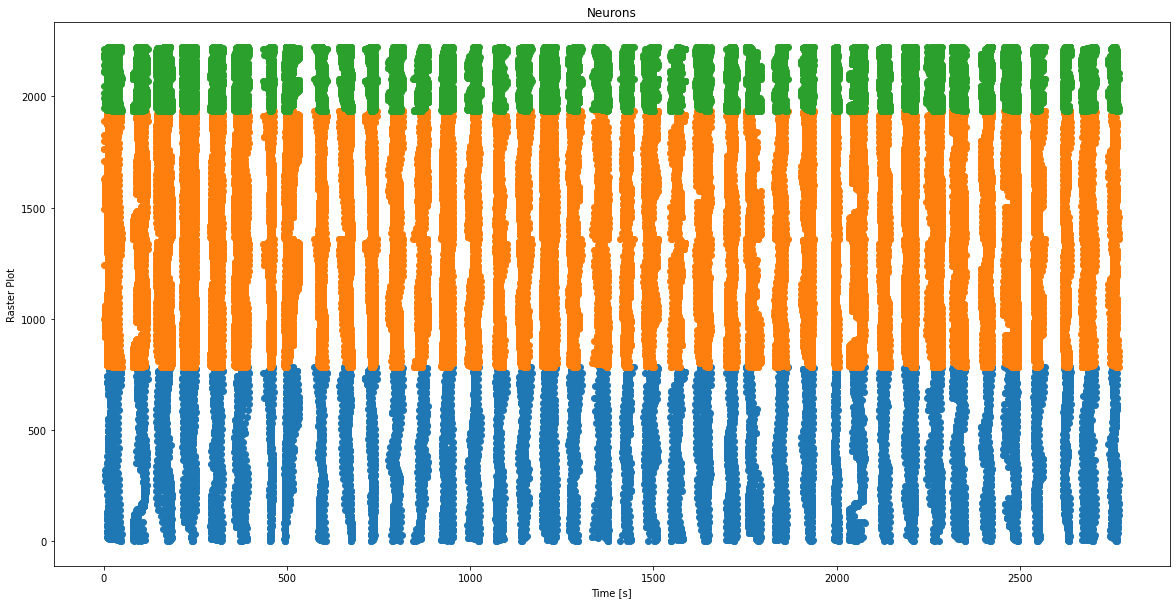

In [28]:
x1 = net["exc_neurons1",0]["spikes",0][:,0]
y1 = net["exc_neurons1",0]["spikes",0][:,1]
x2 = net["exc_neurons2",0]["spikes",0][:,0]
y2 = net["exc_neurons2",0]["spikes",0][:,1]+EXC_SIZE1
x3 = net["exc_neurons3",0]["spikes",0][:,0]
y3 = net["exc_neurons3",0]["spikes",0][:,1]+EXC_SIZE2 + EXC_SIZE1

plt.figure(figsize=(20,10))
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(x3, y3)
plt.ylabel("Raster Plot")
plt.xlabel("Time [s]")
plt.title("Neurons")
plt.show()

# MATRICES OF WEIGHTS DURING LEARNING

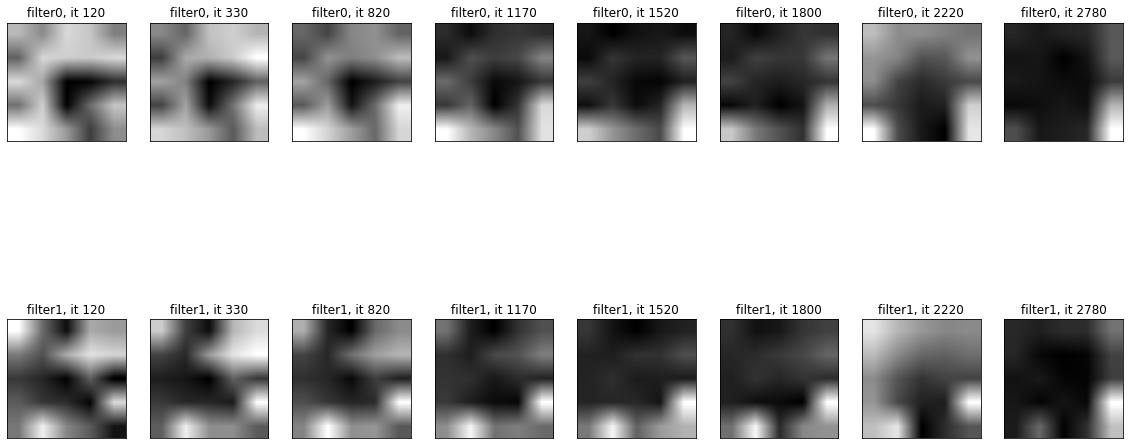

In [29]:
fig, axs = plt.subplots(NUMBER_OF_FEATURES,8, figsize=(20, 10))
# fig.subplots_adjust( hspace=-1,wspace=0.1)

axs = axs.ravel()
number_iter_pic = [2, 5, 12, 17, 22, 26, 32, 40] 
for i in range(len(number_iter_pic)):
    ii = number_iter_pic[i]
    iter_ = (number_iter_pic[i] - 1) * 20 + number_iter_pic[i] * time_window
    w = torch.squeeze(syn1['s.W', 0][iter_])
    w -= w.min()
    w = w/w.max()
    w *= 255

    for j in range(NUMBER_OF_FEATURES):
        pic = cv2.resize(np.array(w[j]), (64, 64))
        axs[i+j].imshow(pic, cmap='gray')
        axs[i+j].set_title('filter' + str(j) + ', it ' + str(iter_))
        axs[i+j].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        i+=7

# FOR RSTDP

# DOPAMINE CHANGES DURING SIMULATION

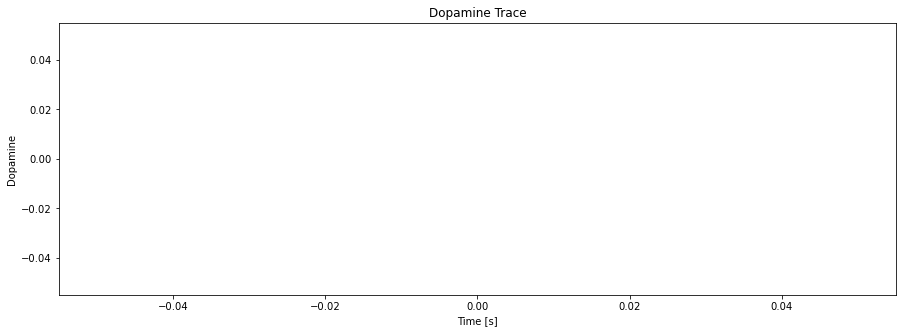

In [30]:
plt.figure(figsize=(15,5))
plt.plot(dopamine_trace)
plt.ylabel("Dopamine")
plt.xlabel("Time [s]")
plt.title("Dopamine Trace")
plt.show()

# PREDICTION

In [31]:
W_learned = syn1['s.W', 0][-1]  #NEW_WEIGHTS

In [32]:
W_learned.shape

torch.Size([2, 1, 5, 5])

In [33]:
pattern_test = []
time_window = 50
face_paths = os.listdir('f_test')
dog_paths = os.listdir('dog_test')
for i, (face_path, dog_path) in enumerate(zip(face_paths, dog_paths)):
    
    face_orginal = Image.open('f_test/'+face_path).convert('L')
    face_orginal = cv2.resize(np.array(face_orginal), (SIZE_X, SIZE_Y))
    face_orginal = np.array(face_orginal, 'f')
    face_orginal = torch.from_numpy(face_orginal)
    
    dog_orginal = Image.open('dog_test/'+dog_path).convert('L')
    dog_orginal = cv2.resize(np.array(dog_orginal), (SIZE_X, SIZE_Y))
    dog_orginal = np.array(dog_orginal, 'f')
    dog_orginal = torch.from_numpy(dog_orginal)
    
    ttfs_face = TimeToFirstSpike(face_orginal, time_window)
    spike_flatten_ttfs_face, spikes_ttfs_face = ttfs_face.encode()
    pattern_test.append(spike_flatten_ttfs_face)
    
    ttfs_dog = TimeToFirstSpike(dog_orginal, time_window)
    spike_flatten_ttfs_dog, spikes_ttfs_dog = ttfs_dog.encode()
    pattern_test.append(spike_flatten_ttfs_dog)

In [34]:
pattern_test = torch.cat(pattern_test, 0)
pattern_test.shape

torch.Size([1200, 784])

In [35]:
pop_params1 = {
    "spike_iter" : pattern_test,
    "E_I" : CURRENT_EXC1,
}

In [36]:
class Predict(Behavior):
    
    def initialize(self, network):
        self.add_tag("Predict")
        self.lst = []
    
    def forward(self, network):
        self.dst_spikes = network.find_objects('GLUTAMATE')[0].dst.spikes
        self.src_spikes = network.find_objects('GLUTAMATE')[0].src.spikes
        self.dst_spikes = self.dst_spikes.view(NUMBER_OF_FEATURES, NUMBER_OF_CHANNELS, OUT_CONV_H, OUT_CONV_W).float()
        feature1_num = torch.squeeze(self.dst_spikes[0]).sum()
        feature2_num = torch.squeeze(self.dst_spikes[1]).sum()
        if (feature1_num - feature2_num) >=0:
            self.lst.append(1)
        else:
            self.lst.append(-1)
        
        r_p = 0
        if network.iteration % 50 == 0:
            
            kharejghesmat = network.iteration // 50
            if kharejghesmat % 2 == 1 and sum(self.lst) > 0:  #face
                r_p = 1
                print('face')
            elif kharejghesmat % 2 == 0 and sum(self.lst) < 0:  #dog
                r_p = 1
                print('dog')
            else:
                r_p = -1
                print('miss')
            self.lst = []

        
        

In [37]:
settings = {"def_type": torch.float32, "device": 'cpu', "synapse_mode": False}
net = Network(settings = settings, behavior={
                                            7: Predict()
                                        # 7: Dopamine(tau_dopamine=10., baseline_dopamine=2.),
                                        # 10: Recorder(["n.dopamine"], auto_annotate=False)  
                                        })
ng_exc1 = NeuronGroup(
    net=net,
    size=EXC_SIZE1,
    tag="exc_neurons1",
    behavior={
        3: LIF_inputlayer(**pop_params1),
        10: EventRecorder(["spikes"]),
    },
)

ng_exc2 = NeuronGroup(
    net=net,
    size=EXC_SIZE2,
    tag="exc_neurons2",
    behavior={
        5: Dendrite(),
        6: LIF_output(**pop_params2),
        8: Recorder(["n.v", "n.I"], auto_annotate=False),
        9: EventRecorder(["spikes"]),
    },
)


syn1 = SynapseGroup(src=ng_exc1, dst=ng_exc2, net=net, tag="GLUTAMATE", behavior={
                                4: ConvolutionalConnection(W=W_learned, coef=500, kernel_size = KERNEL_SIZES,
                                                           stride_conv = STRIDE_CONV, padding=PADDING),
                                2: Trace(tau=5.),
                                            })


net.initialize()
net.simulate_iterations(1200)

Network['Network'](Neurons: tensor(1936)|2 groups, Synapses: tensor(903168)|1 groups){7:Predict()}
NeuronGroup['exc_neurons1', 'NeuronGroup', 'ng'](784){3:LIF_inputlayer(spike_iter=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),E_I=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),)10:EventRecorder(arg_0=['spikes'],)}
NeuronGroup['exc_neurons2', 'NeuronGroup', 'ng'](1152){5:Dendrite()6:LIF_output(E_I=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0.,

1115.3512001037598

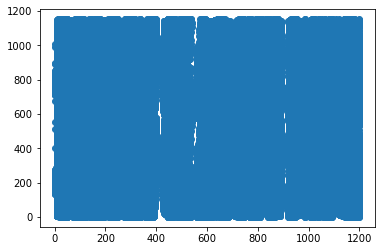

In [38]:
x2 = net["exc_neurons2",0]["spikes",0][:,0]
y2 = net["exc_neurons2",0]["spikes",0][:,1]
plt.scatter(x2, y2)